<a href="https://colab.research.google.com/github/ciepielajan/Multi-Class-Classification-NLP/blob/main/Detecting_intentions_MLP_searching%20_optymal_maxlen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Detecting_intentions_MLP_searching _optymal_maxlen

#### Pobranie danych

In [1]:
# https://drive.google.com/file/d/1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq/view?usp=sharing
!gdown --id "1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq"

Downloading...
From: https://drive.google.com/uc?id=1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq
To: /content/user_intent.zip
100% 271k/271k [00:00<00:00, 39.5MB/s]


In [2]:
!unzip "user_intent.zip"

Archive:  user_intent.zip
  inflating: train.csv               
  inflating: __MACOSX/._train.csv    
  inflating: validation.csv          


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime

data_set_train = pd.read_csv("train.csv")
data_set_valid = pd.read_csv("validation.csv")

print(data_set_train.shape)
print(data_set_valid.shape)

print(data_set_train.columns)
print(data_set_valid.columns)

(13784, 2)
(700, 2)
Index(['text', 'label'], dtype='object')
Index(['text', 'label'], dtype='object')


#### Podstawowy process text

In [4]:
import re
def process_text(sentence):
    sentence = re.sub('[A-Za-z0-9]+@[a-zA-z].[a-zA-Z]+', '', sentence)  # maile
    sentence = re.sub('(http[s]*:[/][/])[a-zA-Z0-9]+', '', sentence)  # linki
    sentence = re.sub(r"<[^>]+>", " ", sentence) # remove html tag
    sentence = re.sub(r"[^a-zA-Z\s]", "", sentence)  # remove punctuations and numbers   
    sentence = re.sub(r"\b[A-Za-z]{1}\b", "", sentence)  # remove single characters

    sentence = re.sub("^\s+|\s+$", "", sentence, flags=re.UNICODE) # Remove spaces both in the BEGINNING and in the END of a string:
    sentence = " ".join(re.split("\s+", sentence, flags=re.UNICODE))  # Remove ONLY DUPLICATE spaces:
    sentence = sentence.lower()
    
    return sentence

In [5]:
data_set_train["clean_text"] = data_set_train["text"].apply(lambda x: process_text(x))

#### Zapoznanie się z rozkłądem intencji
#### Get acquainted with the distribution of words.

In [6]:
df_maxlen = data_set_train['clean_text'].str.split().map(len).describe([0.75, 0.9, 0.95])
df_maxlen

count    13784.000000
mean         8.135882
std          2.847301
min          2.000000
50%          8.000000
75%         10.000000
90%         12.000000
95%         13.000000
max         33.000000
Name: clean_text, dtype: float64

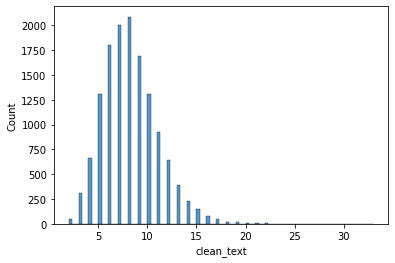

In [7]:
import seaborn as sns
sns.histplot(data_set_train['clean_text'].str.split().map(len))

> W dalszej analizy spradzimy najlepsze rezultaty dla intencji o długości średniej (8), maksymalnej (33) oraz stanowiącej 95% wszystkich wartości(13). 95% ponieważ między 75% a średnią różnica wynosci tylko 2 słowa. 95% jest wartościa pomiędzy średnią a max.

In [8]:
max_len_mean = int(df_maxlen.loc["mean"])
max_len_95 = int(df_maxlen.loc["95%"])
max_len_max = int(df_maxlen.loc["max"])

list_optymal_maxlen = [max_len_mean, max_len_95, max_len_max]
print("lista optymal maxlen",list_optymal_maxlen)

lista optymal maxlen [8, 13, 33]


In [9]:
# Max 
# AVG 

#### `LabelEncoder` oraz `to_categorical`

In [10]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical 


labelencoder = LabelEncoder()
data_set_train["labelencoder"] = labelencoder.fit_transform(data_set_train["label"])

dummy_y = to_categorical(data_set_train["labelencoder"], dtype ="float32")

data_set_train[["clean_text","label","labelencoder"]].head(5)

,clean_text,label,labelencoder
0,find cinema nearest for films,SearchScreeningEvent,6
1,give the current series two stars,RateBook,4
2,find the good girl at movie house,SearchScreeningEvent,6
3,please make reservations for three at kosher t...,BookRestaurant,1
4,what is the forecast for here one second from now,GetWeather,2


In [11]:
dummy_y.shape

(13784, 7)

In [12]:
id_intention = 6
print("Sprawdzenie poprawności LabelEncoder i to_categorical \n")
print("Label - ", data_set_train["label"].iloc[id_intention])
print("LabelEncoder - ", data_set_train["labelencoder"].iloc[id_intention])
print()
print("to_categorical - ", dummy_y[id_intention])
print()
print("return to LabelEncoder - ",np.argmax(dummy_y[id_intention], axis=-1))
print("return to Label - ",labelencoder.inverse_transform([np.argmax(dummy_y[id_intention], axis=-1)]))

Sprawdzenie poprawności LabelEncoder i to_categorical 

Label -  BookRestaurant
LabelEncoder -  1

to_categorical -  [0. 1. 0. 0. 0. 0. 0.]

return to LabelEncoder -  1
return to Label -  ['BookRestaurant']


#### Zdefiniowanie X i y

In [13]:
X = data_set_train["clean_text"]
y = dummy_y

#### Searching  optymal maxlen

In [14]:
from sklearn.model_selection import train_test_split

In [16]:
from keras.models import Sequential
from keras.layers import Flatten, SimpleRNN, Dense
from keras.layers.embeddings import Embedding
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from keras.models import load_model

In [17]:
# df z wynikami  
wyniki = pd.DataFrame(columns=["maxlen","Accuracy","model_name"])
wyniki

,maxlen,Accuracy,model_name


In [18]:
list_optymal_maxlen

[8, 13, 33]

In [19]:
for maxlen in list_optymal_maxlen:
  # Zdefiniowanie X i y
  X = data_set_train["clean_text"]
  y = dummy_y

  #podział na zbiór train i test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # `Tokenizer` i `pad_sequences`
  tokenizer = Tokenizer(num_words=5000)
  tokenizer.fit_on_texts(X_train)

  X_train = tokenizer.texts_to_sequences(X_train)
  X_test = tokenizer.texts_to_sequences(X_test)

  vocab_size = len(tokenizer.word_index) + 1

  X_train = pad_sequences(X_train, padding="post", truncating="post", maxlen=maxlen)
  X_test = pad_sequences(X_test, padding="post", truncating="post", maxlen=maxlen)

  model = Sequential()
  model.add(Embedding(vocab_size, 100, input_length=maxlen))  
  model.add(Flatten())
  model.add(Dense(7, activation="softmax")) # sigmoid / softmax
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  print(model.summary())

  EarlyStop = EarlyStopping(monitor='val_loss', 
                            patience=5,
                            verbose=1)

  history = model.fit(X_train, 
                      y_train, 
                      epochs=30, 
                      batch_size=64, 
                      validation_split=0.2, 
                      callbacks = [EarlyStop] )
  scores = model.evaluate(X_test, y_test)
  print(f"Accuracy {scores[1] * 100}")
  
  #save and del model 
  model.save(f'model_maxlen_{maxlen}.h5')  # creates a HDF5 file 'my_model.h5'
  del model  # deletes the existing model

  wyniki = wyniki.append({"maxlen":maxlen ,"Accuracy":scores[1] * 100,"model_name":f'model_maxlen_{maxlen}'},ignore_index=True)

  
  print("\n=======================================================\n")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 100)            976800    
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 5607      
Total params: 982,407
Trainable params: 982,407
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
138/138 [==============================] - 3s 16ms/step - loss: 1.5886 - accuracy: 0.6644 - val_loss: 0.3926 - val_accuracy: 0.9479
Epoch 2/30
138/138 [==============================] - 2s 12ms/step - loss: 0.2780 - accuracy: 0.9589 - val_loss: 0.1536 - val_accuracy: 0.9683
Epoch 3/30
138/138 [==============================] - 2s 12ms/step - loss: 0.1013 - accur

In [20]:
wyniki

,maxlen,Accuracy,model_name
0,8,98.295248,model_maxlen_8
1,13,98.367792,model_maxlen_13
2,33,98.331517,model_maxlen_33


#### Wyłonienie najlepszego maxlen

In [26]:
maxlen_index = wyniki[wyniki["Accuracy"] == wyniki["Accuracy"].max()].index[0]  # index pierwszego najlepszego wyniku dla Accuracy
maxlen = int(wyniki["maxlen"].iloc[maxlen_index]) # pobranie maxlen dla wskazanego indexu
model_name = wyniki["model_name"].iloc[maxlen_index] # pobranie nazwy modelu dla wskazanego indexu

wyniki.iloc[maxlen_index]

maxlen                     13
Accuracy              98.3678
model_name    model_maxlen_13
Name: 1, dtype: object

#### Wczytanie modelu z największym accuracy 

In [27]:
model = load_model(f'{model_name}.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 13, 100)           976800    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1300)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 9107      
Total params: 985,907
Trainable params: 985,907
Non-trainable params: 0
_________________________________________________________________


#### Predykcja na zbiorze validacyjnym

In [28]:
# oczysczenie danych
data_set_valid["clean_text"] = data_set_valid["text"].apply(lambda x: process_text(x))

# labelencoder 
data_set_valid["labelencoder"] = labelencoder.fit_transform(data_set_valid["label"])

# tokenizacja weg przetrenowanego już tokenizera
X_validate = tokenizer.texts_to_sequences(data_set_valid["clean_text"])

# pad sequel
X_validate = pad_sequences(X_validate, padding="post", truncating="post", maxlen=maxlen)
X_validate

array([[ 15,  42,  50, ...,   0,   0,   0],
       [241, 177,  21, ...,   0,   0,   0],
       [ 15,   8,   1, ...,   2, 174, 997],
       ...,
       [ 28,   1,  84, ...,   0,   0,   0],
       [ 15,   8,   1, ...,   0,   0,   0],
       [ 45,  40,   4, ...,   0,   0,   0]], dtype=int32)

In [29]:
dummy_y_valid = data_set_valid["labelencoder"].values
dummy_y_valid[:5]

array([6, 3, 2, 0, 6])

In [30]:
# Sprawdzenie rozmiaru zbiorów validacyjnego
X_validate.shape, dummy_y_valid.shape

((700, 13), (700,))

In [31]:
predicted_lstm_val = np.argmax(model.predict(X_validate), axis=-1)
predicted_lstm_val[:5]

array([6, 3, 2, 0, 6])

#### Rozkodowanie przewidzianych i prawidłowych etykiet

In [32]:
y_pred = labelencoder.inverse_transform(predicted_lstm_val)
y_pred = pd.Series(y_pred)
y_pred.head()

0    SearchScreeningEvent
1               PlayMusic
2              GetWeather
3           AddToPlaylist
4    SearchScreeningEvent
dtype: object

In [33]:
y_val = labelencoder.inverse_transform(dummy_y_valid)
y_val = pd.Series(y_val)
y_val.head()

0    SearchScreeningEvent
1               PlayMusic
2              GetWeather
3           AddToPlaylist
4    SearchScreeningEvent
dtype: object

#### `Confusion matrix`

In [34]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

Accuracy: 0.98
F1_score: 0.98
                      precision    recall  f1-score   support

       AddToPlaylist       0.98      1.00      0.99       100
      BookRestaurant       1.00      0.99      0.99       100
          GetWeather       0.99      0.99      0.99       100
           PlayMusic       1.00      0.97      0.98       100
            RateBook       1.00      1.00      1.00       100
  SearchCreativeWork       0.92      1.00      0.96       100
SearchScreeningEvent       1.00      0.93      0.96       100

            accuracy                           0.98       700
           macro avg       0.98      0.98      0.98       700
        weighted avg       0.98      0.98      0.98       700



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

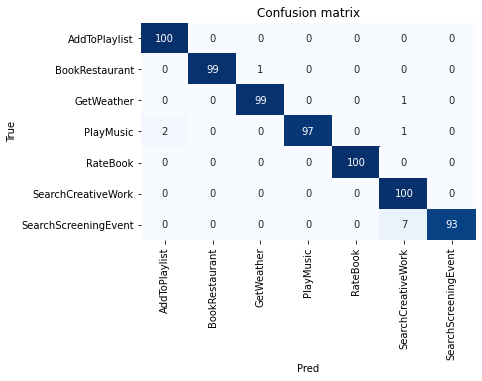

In [35]:
classes = np.unique(y_val)

print('Accuracy:', round(accuracy_score(y_val, y_pred),2))
print('F1_score:', round(f1_score(y_val, y_pred, average='weighted'),2))

print(classification_report(y_val, y_pred))
# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel='Pred', ylabel='True', xticklabels=classes, yticklabels=classes, title='Confusion matrix')
plt.yticks(rotation=0)
plt.xticks(rotation=90)

#### Zapoznanie się z błędnymi predykcjami 

In [36]:
indexes = []
for i, phrase in enumerate(y_pred):
  if phrase == 'SearchCreativeWork':
    if y_val[i] == 'SearchScreeningEvent':
      indexes.append(i)
print(indexes)

[451, 519, 557, 568, 615, 648, 689]


In [38]:
for i in indexes:
  print(f"----------------------------\nTekst komendy id {i}:\n{data_set_valid['text'][i]}")
  print(f"Oczyszczona komenda i skrócona do wartości maxlen={maxlen}:\n{' '.join(data_set_valid['clean_text'][i].split()[:maxlen])}")
  print(f'True category: {y_val[i]}')
  print(f'Predicted category: {y_pred[i]}')
  print("\n")

----------------------------
Tekst komendy id 451:
Can I see Ellis Island Revisited in 1 minute
Oczyszczona komenda i skrócona do wartości maxlen=13:
can see ellis island revisited in minute
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy id 519:
i want to see JLA Adventures: Trapped In Time
Oczyszczona komenda i skrócona do wartości maxlen=13:
want to see jla adventures trapped in time
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy id 557:
I want to see Shattered Image.
Oczyszczona komenda i skrócona do wartości maxlen=13:
want to see shattered image
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy id 568:
Can you check the timings for Super Sweet 16: The Movie?
Oczyszczona komenda i skrócona do wartości maxlen=13:
can you check the timings for super sweet the movie
True c

Wnioski:
> Najlepszy wynik Accuracy: 0.98 i  F1_score: 0.98 osiągneliśmy na parametrze `maxlen` o wartości 13 ( czyli ilość słow która określa 95% wszystkich intencji w zbiorze)